In [1]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import os
import re
import json
import presto  # import prestosql python client
import psycopg2
import warnings

import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt

import altair as alt
from altair import datum
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import datetime
warnings.simplefilter('ignore', InsecureRequestWarning)

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
alt.data_transformers.disable_max_rows()
uid = "_svc_acs_presto"
pwd = "em6qF7Gp8E9ECYcKx3gHZ#v$H@pzT7AX3uCJp%5wesKE%VD6gZaCB8*rZ2zNgMKdPkuetSJph2H&H2eadbfCkeB3tBbUqcM^Sj5k"

conn = presto.dbapi.connect(host='acs-exports.bi.ghdna.io',
                            port=8446,
                            user='_svc_acs_presto',
                            catalog='hive',
                            schema='default',
                            http_scheme='https',
                            verify=False,
                            auth=presto.auth.BasicAuthentication(uid, pwd))
cur = conn.cursor()


def get_conn(db):
    conn = psycopg2.connect(db)
    return conn


def get_cursor(conn):
    
    cursor = conn.cursor()
    return cursor


def statement_to_df(cursor):
    df = pd.DataFrame(cursor.fetchall(), columns=[i[0] for i in cursor.description])
    return df


prod = f"host='ghdb-prod.bi.ghdna.io' dbname='ghdb' user='scientist' password='gh-scientist-rocks!'"

GHDB_prod_conn = get_conn(prod)
GHDB_prod_cursor = get_cursor(GHDB_prod_conn)
pd.options.display.max_rows = 4000

### Plot LPC quant and ENC quant of AV360-388 on heatmap

In [37]:
av388_data = pd.read_csv('av388_lpc_enc_quant_data.csv').rename(columns = {'molarity_EN':'EN_molarity'})
av388_data['row'] = av388_data['Position'].str[0]
av388_data['column'] = av388_data['Position'].str[2].astype('str')
av388_data.head()

,batch_name,Position,Sample,LPC_Conc,EN_molarity,row,column
0,AV360-388,A:1,600100387,28.2,141.00,A,1
1,AV360-388,B:1,T12_EIO_S1_R01,30.5,8.74,B,1
2,AV360-388,C:1,T12_EIO_S1_R02,29.2,7.83,C,1
3,AV360-388,D:1,T12_EIO_S1_R03,29.0,7.89,D,1
4,AV360-388,E:1,T12_EIO_S1_R04,28.1,8.46,E,1


In [38]:
data_plate_pos = pd.melt(av388_data, id_vars=['batch_name', 'Sample','row', 'column'], value_vars=['LPC_Conc', 'EN_molarity'])
data_plate_pos['status'] = data_plate_pos[['variable', 'value', 'Sample']].apply(lambda x: 'PASS' if (x['variable'] == 'EN_molarity' and (x['Sample'] != 'NTC_1' and  x['Sample'] != 'T12_EIO_S0_R01') and (x['value'] >= 0.35 and x['value'] <= 130)) 
else ('PASS' if (x['variable'] == 'EN_molarity' and (x['Sample'] == 'NTC_1' or x['Sample'] == 'T12_EIO_S0_R01') and (x['value'] <= 0.2)) else( 'PASS' if x['variable'] == 'LPC_Conc' else 'FAIL')), axis = 1)
                                                                                                                                                               
data_plate_pos['label'] =  round(data_plate_pos['value'], 3).astype('str')

data_plate_pos.loc[(data_plate_pos['batch_name'] == 'AV360-388_ReEN') & (data_plate_pos['variable'] == 'EN_molarity'), 'variable'] = 'Re-EN Molarity'
data_plate_pos.loc[data_plate_pos['batch_name'] == 'AV360-388_ReEN', 'batch_name'] = 'AV360-388'
data_plate_pos = data_plate_pos.drop_duplicates()
data_plate_pos.head()
data_plate_pos.head()

,batch_name,Sample,row,column,variable,value,status,label
0,AV360-388,600100387,A,1,LPC_Conc,28.2,PASS,28.2
1,AV360-388,T12_EIO_S1_R01,B,1,LPC_Conc,30.5,PASS,30.5
2,AV360-388,T12_EIO_S1_R02,C,1,LPC_Conc,29.2,PASS,29.2
3,AV360-388,T12_EIO_S1_R03,D,1,LPC_Conc,29.0,PASS,29.0
4,AV360-388,T12_EIO_S1_R04,E,1,LPC_Conc,28.1,PASS,28.1


In [8]:
data_plate_pos.variable.unique()

array(['LPC_Conc', 'EN_molarity'], dtype=object)

In [39]:
# data_plate_pos_sub = data_plate_pos[data_plate_pos.variable.isin(['latest_molarity_EN', 'original_molarity_EN'])]
domain = ['PASS', 'FAIL']
range_ = ['black', 'blue']



heatmap = alt.Chart(data_plate_pos).mark_rect().encode(
    x=alt.X('column:O', 
            title='Column', 
            axis=alt.Axis(labelAngle=0)
           ),
    y=alt.Y('row:O', 
            title='Row'
           ),
    tooltip=['variable', 'value'],
    color=alt.Color('value:Q', scale=alt.Scale(scheme='lightorange', domainMid=0.35))
    
).properties(
    width=500,
    height=400
)

text = alt.Chart(data_plate_pos).mark_text(size=14).encode(
    x=alt.X('column:O', 
            title='Column'
           ),
    y=alt.Y('row:O', 
            title='Row'
           ),
    color = alt.Color('status:N', scale=alt.Scale(domain=domain, range=range_)),
    text=alt.Text('label:N')
)


(heatmap + text).facet(
    column= alt.Column('variable:N', sort=['LPC_Conc', 'EN_molarity', 'Re-EN Molarity']),
    row='batch_name'

).properties(
    title=alt.TitleParams(f'Quant Metric of AV360-388',
                          anchor='middle',
                          fontSize=15,
                          dy=-10)
).resolve_scale( 
      color='independent'
).resolve_axis(
    x='independent', y='independent'
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=14
).configure_facet(
    spacing=20
).configure_header(
    titleFontSize=14,
    labelFontSize=14
)

alt.FacetChart(...)

### Check to see if there are systematic instrument issues

In [20]:
g360_data = pd.read_csv('/ghds/projects/labdesk/jiwang/proactive_monitoring/acs_exports/g360_reagent_instrument_qc_metric.csv')
g360_data.head()

/home/jiwang/miniconda3/envs/my_environment/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,6,7,8,9,10,14,18,20,23,24,25,26,27,28,29,33,34,35,92) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,acs_instance,batch_name,stage,operation_name,created_YYMMDD,Re_enrich_YYMMDD,Re_pooling_YYMMDD,Ori_pooling_YYMMDD,is_repeat,is_rerun,is_final,variable,value,batch_no,run_sample_id,total_yield,latest_molarity_EN,original_molarity_EN,ex_row,ex_column,en_row,en_column,molarity_EN,project,sample_type,gender,runid,flowcell_id,connection_id,NextSeq,NextSeq_Buffer_Cartridge,NextSeq_Reagent_Cartridge,NextSeq_Flowcell_Cartridge,seq_run_date,seq_YYMM,seq_YYMMDD,flowcell_aio_controls,flowcell_autoqc_total,flowcell_cluster_density,flowcell_cluster_density_max,flowcell_clusters_passing_filter,flowcell_phasing_1,flowcell_phasing_2,flowcell_phasing_index,flowcell_prephasing_1,flowcell_prephasing_2,flowcell_prephasing_index,flowcell_qscore_1,flowcell_qscore_2,flowcell_qscore_index,aiocontrol_false_positive_cnv,aiocontrol_false_positive_fusion,aiocontrol_false_positive_indel,aiocontrol_false_positive_msi,aiocontrol_false_positive_snv,aiocontrol_sensitivity_cnv,aiocontrol_sensitivity_fusion,aiocontrol_sensitivity_indel,aiocontrol_sensitivity_msi,aiocontrol_sensitivity_snv,num_germline_brca_biallelic,pathogenic_germline_num,sample_autoqc_total,sample_contamination_pct,sample_coverage_exceptions,sample_dectree_raises_max_som_maf,sample_distbin_raises_max_som_maf,sample_distbin_vs_dectree,sample_female_chry_molecules,sample_fusions_with_two_molecules,sample_gc_bias,sample_gender_status_mismatch,sample_germline_contamination,sample_germline_variance,sample_missing_mut_aa,sample_multiple_complex_indel,sample_multiple_low_fd,sample_non_singleton_families,sample_on_target_rate,sample_pval_vs_distbin,sample_single_molecule_indel,sample_somatic_max_pct,sample_suppressed_onesnp_upper,sample_too_many_fusion_genes,sample_too_many_fusions,sample_whitelist_germline_distbin,sample_whitelist_germline_pval,diversity,day_diff,lp_input,norm_en,conversion_rate,ex_bin
0,acs_default_clia,CLIA-1090,Extraction,Prepare Extraction Reagents,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,QIASymphony_Circulating_DNA_Kit,163037647,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Clinical,Female,200127_NB551240_0313_AHG5M7BGXC,HG5M7BGXC,Flowcell ID A,NSQ00014,20404513.0,20383557.0,20383185.0,2020-01-27 00:00:00,2020-01,2020-01-27,1.0,23.0,207750.0,NaN,89.3,0.001,0.0013,0.0,0.0005,0.0007,0.0,92.0,89.74,95.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,0.01,233.0,NaN,NaN,NaN,0.0,NaN,372.67,0.0,0.0,NaN,NaN,NaN,NaN,1208.0,90.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,-1.0,30.0,0.100333,0.217778,>30
1,acs_default_clia,CLIA-1090,Extraction,QIASymphony Extraction,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,PBS_with_EDTA_1x,P020302G1901,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Clinical,Female,200127_NB551240_0313_AHG5M7BGXC,HG5M7BGXC,Flowcell ID A,NSQ00014,20404513.0,20383557.0,20383185.0,2020-01-27 00:00:00,2020-01,2020-01-27,1.0,23.0,207750.0,NaN,89.3,0.001,0.0013,0.0,0.0005,0.0007,0.0,92.0,89.74,95.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,0.01,233.0,NaN,NaN,NaN,0.0,NaN,372.67,0.0,0.0,NaN,NaN,NaN,NaN,1208.0,90.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,-1.0,30.0,0.100333,0.217778,>30
2,acs_default_clia,CLIA-1090,Extraction,QIASymphony Extraction,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,QIASymphony,QSY00004,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Clinical,Female,200127_NB551240_0313_AHG5M7BGXC,HG5M7BGXC,Flowcell ID A,NSQ00014,20404513.0,20383557.0,20383185.0,2020-01-27 00:00:00,2020-01,2020-01-27,1.0,23.0,207750.0,NaN,89.3,0.001,0.0013,0.0,0.0005,0.0007,0.0,92.0,89.74,95.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,0.01,233.0,NaN,NaN,NaN,0.0,NaN,372.67,0.0,0.0,NaN,NaN,NaN,NaN,1208.0,90.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,-1.0,30.0,0.100333,0.217778,>30
3,acs_default_clia,CLIA-1090,Extraction,Prepare Tapestation EX,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,SPK2,000000258,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Cli

In [21]:
g360_data.acs_instance.unique()

array(['acs_default_clia', 'acs-g360-iuo-default', 'acs_qc_default_p360q',
       'acs_ruo_default', 'mdacc_default'], dtype=object)

#### Check to see if STA15 has recent issue of high EN Molarity failure during last month

In [23]:
g360_data_sub = g360_data[(g360_data.acs_instance == 'acs_default_clia') & (g360_data.variable == 'ENW_STAR') & (g360_data.created_YYMMDD >= '2024-01-13') & (g360_data.created_YYMMDD <= '2024-02-13')][['batch_name', 'batch_no','variable','value','created_YYMMDD', 'run_sample_id', 'sample_type', 'en_row', 'en_column', 'total_yield', 'molarity_EN']].drop_duplicates()
g360_data_sub.head()

,batch_name,batch_no,variable,value,created_YYMMDD,run_sample_id,sample_type,en_row,en_column,total_yield,molarity_EN
442314,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094290801,Clinical,B,1.0,312.90,6.19
442359,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094291701,Clinical,C,1.0,10.78,1.98
442404,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094293701,Clinical,D,1.0,15.54,1.41
442449,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094159201,Clinical,E,1.0,29.61,7.61
442494,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094170701,Clinical,F,1.0,25.69,6.61


In [24]:
g360_data_sub.sample_type.unique()

array(['Clinical', nan, 'Pharma', 'Validation'], dtype=object)

In [25]:
g360_data_sub.variable.unique()

array(['ENW_STAR'], dtype=object)

In [26]:
g360_data.acs_instance.unique()

array(['acs_default_clia', 'acs-g360-iuo-default', 'acs_qc_default_p360q',
       'acs_ruo_default', 'mdacc_default'], dtype=object)

In [16]:
g360_data_sub.head()

,batch_name,batch_no,variable,value,created_YYMMDD,run_sample_id,sample_type,en_row,en_column,total_yield,molarity_EN
442314,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094290801,Clinical,B,1.0,312.90,6.19
442359,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094291701,Clinical,C,1.0,10.78,1.98
442404,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094293701,Clinical,D,1.0,15.54,1.41
442449,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094159201,Clinical,E,1.0,29.61,7.61
442494,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,A094170701,Clinical,F,1.0,25.69,6.61


In [27]:
g360_data_sub_en = g360_data_sub[(g360_data_sub.en_row == 'A') & (g360_data_sub.en_column.isin([1, 4]))]
g360_data_sub_en['sta_category'] = g360_data_sub_en['value'].apply(lambda x: 'STA00015' if x == 'STA00015' else 'other_STAs')
g360_data_sub_en.head()

/home/jiwang/miniconda3/envs/my_environment/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,batch_name,batch_no,variable,value,created_YYMMDD,run_sample_id,sample_type,en_row,en_column,total_yield,molarity_EN,sta_category
444249,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,600100106,NaN,A,4.0,NaN,1.19,other_STAs
444294,CLIA-7806,7806.0,ENW_STAR,STA00018,2024-01-14,600100105,NaN,A,1.0,NaN,1.90,other_STAs
445419,CLIA-7823,7823.0,ENW_STAR,STA00027,2024-01-19,600100467,NaN,A,4.0,NaN,2.40,other_STAs
447534,CLIA-7833,7833.0,ENW_STAR,STA00074,2024-01-20,600100499,NaN,A,4.0,NaN,2.72,other_STAs
447579,CLIA-7833,7833.0,ENW_STAR,STA00074,2024-01-20,600100500,NaN,A,1.0,NaN,5.32,other_STAs


#### Plot the EN Molarity by STA category in box plot and scatter plot

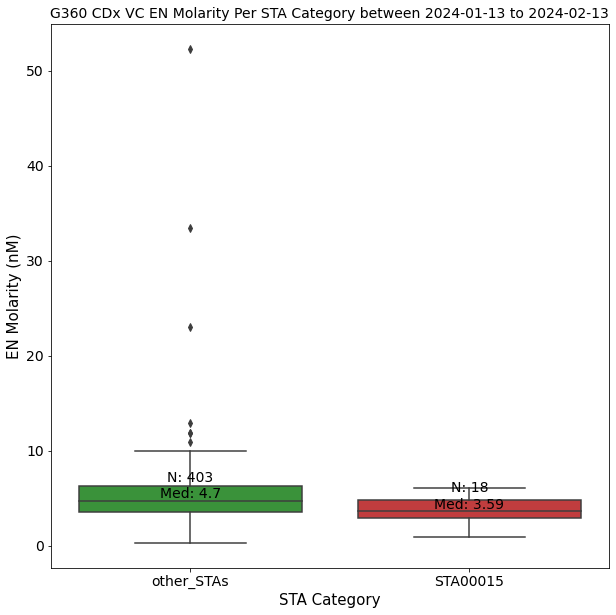

In [35]:
# Define the color mapping
color_mapping = {
    "other_STAs": "#2ca02c",
    "STA00015": "#d62728"
}

sta_values = ["other_STAs", "STA00015"]

# Calculate medians for each sta_category
medians = g360_data_sub_en.groupby("sta_category")["molarity_EN"].median()
sta_values_sorted = sorted(sta_values, key=lambda x: -medians[x])


plt.figure(figsize=(10, 10))
colors = [color_mapping[sta] for sta in sta_values_sorted]
sns.set_palette(colors)
sns.boxplot(data=g360_data_sub_en, x="sta_category", y="molarity_EN", showfliers=True, order=sta_values_sorted )
# sns.boxplot(data=g360_data_sub_en, x="sta_category", y="molarity_EN", showfliers=False, order=sta_values_sorted)

# Annotate each boxplot with sample size (N) and median (Med)
sample_sizes = g360_data_sub_en.groupby("sta_category")["molarity_EN"].count()

for i, label in enumerate(sta_values_sorted):
    median_val = medians[label]
    sample_size_val = sample_sizes[label]
    median_val_rounded = round(median_val, 2)
    
    text = f"N: {sample_size_val}\nMed: {median_val_rounded}"
    
    # Annotate above each boxplot
    plt.annotate(text, xy=(i, median_val), ha="center", va="bottom", fontsize=14)

# Add labels to the axes
plt.xlabel("STA Category", fontsize=15)
plt.ylabel("EN Molarity (nM)", fontsize=15)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)

plt.title(f"G360 CDx VC EN Molarity Per STA Category between 2024-01-13 to 2024-02-13", fontsize=14)

plt.savefig("G360_EIO_stability_troubleshooting_molarity_en_by_STA.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [28]:
## Plot by color by each STA category
sta_en_molarity_scatterplot = alt.Chart(g360_data_sub_en).mark_circle(size=25).encode(#(outliers=False, size=25).encode(
    x=alt.X(f'created_YYMMDD:N',
            title=f'Run Date',
            axis=alt.Axis(labelAngle=-45,
                          labelOverlap=False),
#             tooltip=['pacific_time', 'qscore_index']
            ),
    y=alt.Y('molarity_EN:Q',
            title='EN Molarity',
            scale=alt.Scale(zero=False)
            ),
    color=alt.Color(f'sta_category:N', title='STA Category', legend=alt.Legend(title="Hamilton STA", orient="right")),
).properties(
    width=800,
    height=250,
    title=alt.TitleParams(text=f'G360 CDx VC (A1 and A4)EN Molarity by ENW STA Category between 2024-01-13 to 2024-02-13',
                          anchor='middle',
                          fontSize=15,
                          dy=-10)
)
line1 = alt.Chart(pd.DataFrame({'y': [0.35]})).mark_rule(strokeDash=[10, 10],color = 'red').encode(y='y')
# line2 = alt.Chart(pd.DataFrame({'y': [200]})).mark_rule(strokeDash=[10, 10],color = 'red').encode(y='y')
sta_en_molarity_scatterplot + line1

alt.LayerChart(...)